# Setup

## Imports

In [1]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


ArgumentError: ArgumentError: Package ProgressMeter not found in current path.
- Run `import Pkg; Pkg.add("ProgressMeter")` to install the ProgressMeter package.

## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

UndefVarError: UndefVarError: `MiniLoggers` not defined

# Loading Model and json

In [3]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3LargeTransmon/Mode3LargeTransmon.json");
proj_dict = SC.Utils.Get_Projection_Ops(Mode3.dressed_states);

device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [4]:
GLOBAL_SAVE_CALIBRATE = true;

# Calibrating Pulses

## Sidebands at $\varepsilon = 0.735$

### Getting Stark Shift

┌ Info: Beginning Floquet Sweep
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/Floquet.jl:30
Progress: 100%|█████████████████████████████████████████| Time: 0:03:12
┌ Info: Done With Floquet Sweep
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/Floquet.jl:92
Progress:  18%|███████▌                                 |  ETA: 0:00:01┌ Info: Fit Stuff: 3-element Vector{Float64}:
│  0.037665785358891535
│  0.002438961631085492
│  2.1276949545747126
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/PulseFinder.jl:69


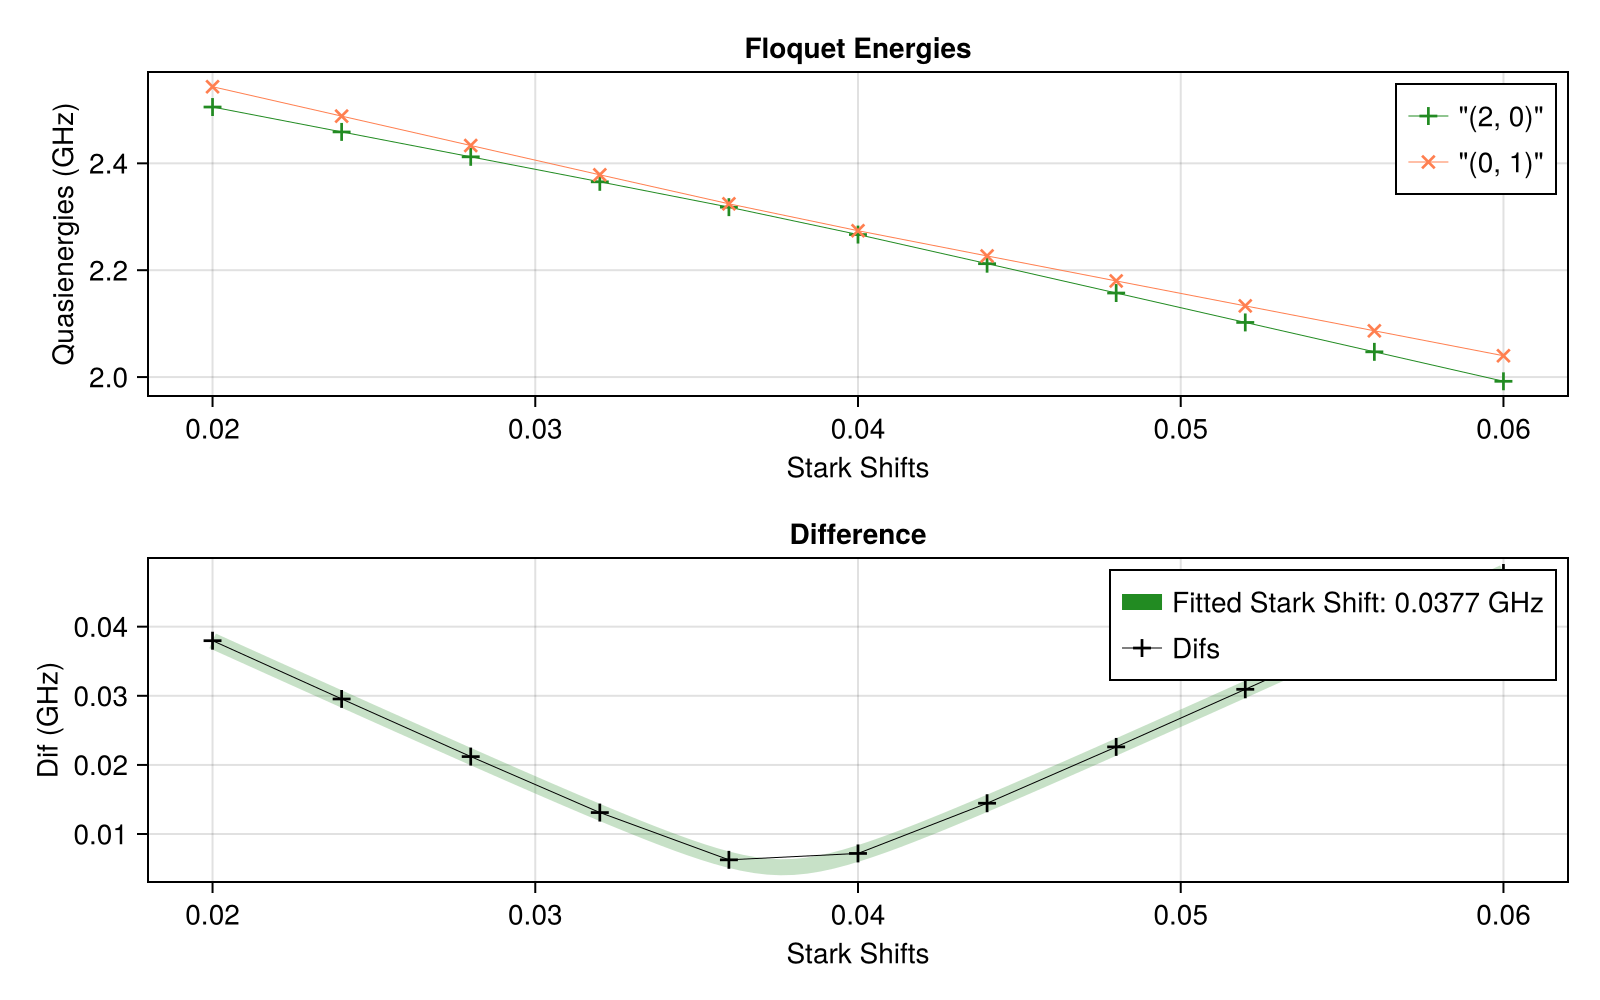

Stark shift res: [0.037665785358891535, 192.7017541703714]


In [5]:
fngnp1_ε = 0.735
drive_op = Mode3.n̂ₜ
state1 = (2,0)
state2 = (0,1)

stark_shift_list = collect(LinRange(0.02, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode3, state1, state2, fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
fngnp1_stark_shift = stark_shift_res[1];
fngnp1_start_time = stark_shift_res[2];

In [6]:
fngnp1_ramp_time = 11.6257;

### f0->g1


In [7]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][3][1]*1000))

Target flattop time: 181.36160714285714


In [8]:
ψ1 = Mode3.dressed_states[(2,0)]
ψ2 = Mode3.dressed_states[(0,1)]

freq_d = Mode3.dressed_energies[(0,1)]-Mode3.dressed_energies[(2,0)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time, fngnp1_start_time+fngnp1_ramp_time*2]

optimize_res_f0g1 = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

┌ Info: On Level 1
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/PulseFinder.jl:146
┌ Info: On Step 1: t = 192.7017541703714
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/PulseFinder.jl:153
┌ Info: Running Time Evolution
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/RunOperatorSequence.jl:110


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 46s (ETA: 0h 00m 00s)


┌ Info: Time Evolution Complete
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/RunOperatorSequence.jl:115
┌ Info: Done with Level_1_step_1
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/RunOperatorSequence.jl:143
┌ Info: Accurace: 0.9895595490717406
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/PulseFinder.jl:171
┌ Info: ------------------------------------------------------------------------------
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/PulseFinder.jl:172
┌ Info: On Step 2: t = 198.5146041703714
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/PulseFinder.jl:153
┌ Info: Running Time Evolution
└ @ Superconductin

Progress: [=                             ]   5.5% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 34s)

InterruptException: InterruptException:

In [9]:
optimize_res_f0g1["pulse_time"]-optimize_res_f0g1["Envelope Args"]["ramp_time"]*2

UndefVarError: UndefVarError: `optimize_res_f0g1` not defined

In [10]:
#Mode3.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1)
end

UndefVarError: UndefVarError: `optimize_res_f0g1` not defined

In [11]:
ψ = Mode3.dressed_states[(2,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
sb_f0g1_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["sb_f0g1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_Sat-Nov-16-24.16.25
It is being saved at: Data/


┌ Info: Running operator sb_f0g1
└ @ SuperconductingCavities.Dynamics /Users/gavinrockwood/Documents/Git Repositories/SuperconductingCavities/src/Dynamics/RunOperatorSequence.jl:304


KeyError: KeyError: key "sb_f0g1" not found

In [12]:
EVs_f0g1 = SC.Utils.Get_EVs(sb_f0g1_res["states"], proj_dict);

UndefVarError: UndefVarError: `sb_f0g1_res` not defined

In [13]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, sb_f0g1_res["times"], EVs_f0g1, plot_every = 10)

UndefVarError: UndefVarError: `sb_f0g1_res` not defined